In [1]:
import gym
import MCTSnet
import copy
import torch

In [2]:
env = gym.make("SokobanEnc-v0")

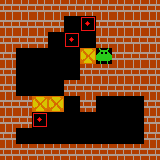

In [3]:
env.render()

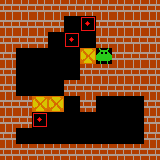

In [4]:
res = env.step(3)
env.render()

In [13]:
res

(array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
         [1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
         [1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [1, 1, 0, 0, 0, 1, 0, 0, 0, 1],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 
        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
         [

In [5]:
e = MCTSnet.models.embedding.Epsilon()

In [6]:
state = torch.Tensor(res[0])
state.reshape((-1,4,10,10)).shape

torch.Size([1, 4, 10, 10])

In [8]:
embed = e.forward(state.reshape((-1, 4, 10, 10)))

In [17]:
reward = torch.tensor([res[1]], requires_grad=True)
action = torch.tensor([3.], requires_grad=True)

In [19]:
b = MCTSnet.models.backup.BetaMLP()

In [21]:
b(embed, embed, reward.reshape((-1, 1)), action.reshape((-1, 1)))

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 128 and 1 in dimension 1 at c:\a\w\1\s\windows\pytorch\aten\src\th\generic/THTensorMoreMath.cpp:1307